## Utility functions

In [2]:
%matplotlib inline
from nltk.cluster.kmeans import KMeansClusterer
import nltk
import pickle

import torch
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertModel
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertPreTrainingHeads
import numpy as np
from scipy.spatial.distance import cosine
import pickle
import re
import pandas as pd
device = 'cpu'
import sys
import os

import json


In [3]:
class BertForPreTraining_custom(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining_custom, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        output_all_encoded_layers=True
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=output_all_encoded_layers)
        if output_all_encoded_layers:
            sequence_output_pred = sequence_output[-1]
        prediction_scores, seq_relationship_score = self.cls(sequence_output_pred, pooled_output)
        return prediction_scores, seq_relationship_score, sequence_output, pooled_output 
    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_json_file('../data/bert_config.json')
bert_model = 'bert-base-uncased'

In [4]:
def getNSPScore(sample_text):
    
    m = torch.nn.Softmax()

    tokenized_text = tokenizer.tokenize(sample_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [0]*tokenized_text.index('[SEP]')+[1]*(len(tokenized_text)-tokenized_text.index('[SEP]'))

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    pred_score, seq_rel, seq_out, pool_out = model1(tokens_tensor, segments_tensors)
    return m(seq_rel).detach().numpy()[0][0] #returns probability of being next sentence

def getSentMatchScore(sent1, sent2, nsp_dampening_factor = 0.7):
    
    sent1_feats = getBERTFeatures(model1, sent1, attn_head_idx)
    sent2_feats = getBERTFeatures(model1, sent2, attn_head_idx)
    
    cosine_distance = 1- cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    #print ("nsp score -> " + str(nsp_score))
    #print ("cosine score -> " + str(cosine_distance))
    return score
    

def getSentMatchScore_wfeature(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    #return cosine_distance
    nsp_input1 = sent1+' [SEP] '+sent2
    #nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    #nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = nsp_score_1 * nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score

def getSentMatchScore_wfeature_cosine(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    return cosine_distance
    

def getSentMatchScore_wfeature_test(sent1, sent2, sent1_feats, sent2_feats, nsp_dampening_factor = 0.7):
    cosine_distance = 1-cosine(sent1_feats, sent2_feats)
    
    nsp_input1 = sent1+' [SEP] '+sent2
    nsp_input2 = sent2+' [SEP] '+sent1
    
    nsp_score_1 = getNSPScore(nsp_input1)
    nsp_score_2 = getNSPScore(nsp_input2)
    
    nsp_score = np.mean([nsp_score_1,nsp_score_2])*nsp_dampening_factor
    #nsp_score = nsp_score_1*nsp_dampening_factor
    
    len_diff = abs(len(sent1.split(' '))-len(sent2.split(' ')))
    if len_diff>2*(min(len(sent1.split(' ')),len(sent2.split(' ')))):
        #give more weight to nsp if the sentences of largely varying lengths
        score = 0.4*cosine_distance+0.6*nsp_score
    else:
        score = np.mean([cosine_distance,nsp_score])
    
    return score, cosine_distance, nsp_score
def getBERTFeatures(model, text, attn_head_idx = -1): #attn_head_idx - index o[]
    tokenized_text = tokenizer.tokenize(text)
    if len(tokenized_text)>200:
        tokenized_text = tokenized_text[0:200]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    _, _, seq_out, pool_out = model(tokens_tensor)
    seq_out = list(getPooledFeatures(seq_out[attn_head_idx]).T)
    #pool_out = list(pool_out.detach().numpy().T)
    
    return seq_out

def getPooledFeatures(np_array):
    np_array = np_array.reshape(np_array.shape[1],np_array.shape[2]).detach().numpy()
    np_array_mp = np.mean(np_array, axis=0).reshape(1, -1)
    return np_array_mp

def replaceContractions(text):
    #text = text.lower()
    c_filt_text = ''
    for word in text.split(' '):
        if word in contractions:
            c_filt_text = c_filt_text+' '+contractions[word]
        else:
            c_filt_text = c_filt_text+' '+word
    return c_filt_text

def cleanText(text):
        
    text = text.replace('\\n','')
    text = text.replace('\\','')
    #text = text.replace('\t', '')
    #text = re.sub('\[(.*?)\]','',text) #removes [this one]
    text = re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?\s',
                ' __url__ ',text) #remove urls
    #text = re.sub('\'','',text)
    #text = re.sub(r'\d+', ' __number__ ', text) #replaces numbers
    text = re.sub('\W', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    return text

In [5]:
model1 = BertForPreTraining_custom(config)
model1.to(device)
#state_dict_1 = torch.load('/home/ether/domain_mind/ai/bert_10epc_ai_ds_1e-6_sl40.bin')
state_dict_1 = torch.load('../data/bert_10epc_se_1e-6_sl40.bin')
model1.load_state_dict(state_dict_1)
model1.eval()

BertForPreTraining_custom(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): 

## getting communities out of slack dump

In [7]:
import sys, pickle
sys.path.append('../')
import text_preprocessing.preprocess as tp

with open('../data/engg_text_06May19_recency.pkl','rb') as fp:
    file = pickle.load(fp)

texts = '. '.join(sent for sent in file)

mod_texts_unfiltered = tp.preprocess(texts, stop_words=False, remove_punct=True)
mod_texts = []

for index, sent in enumerate(mod_texts_unfiltered[:500]):
    if len(sent.split(' '))>250:
        length = len(sent.split(' '))
        split1 = ' '.join([i for i in sent.split(' ')[:round(length/2)]])
        split2 = ' '.join([i for i in sent.split(' ')[round(length/2):]])
        mod_texts.append(split1)
        mod_texts.append(split2)
        continue
        #mod_texts.pop(index)
    if len(sent.split(' '))<=6:
        continue
    mod_texts.append(sent)

print(len(mod_texts))
fv = {}

for index, sent in enumerate(mod_texts):
    fv[index] = getBERTFeatures(model1, sent, attn_head_idx=-1)
    print (index)
print (mod_texts)

368
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [8]:
import networkx as nx

def build_graph(doc_list):
    eng_graph = nx.Graph()
    try:
        eng_graph.add_nodes_from(range(len(doc_list)))
    except Exception as e:
        print(e)
    return eng_graph


tg = build_graph(mod_texts)

In [9]:
tg.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [ ]:
attn_head_idx = -1

node_edge = []

for index1, sent1 in enumerate(mod_texts):
    print (index1)
    for index2, sent2 in enumerate(mod_texts):
        if index1!=index2:
            score = getSentMatchScore_wfeature(sent1, sent2,fv[index1],fv[index2])
            if score > 0.8:
                #tg.add_edge(index1,index2,{'weight': score})
                tg.add_edge(index1,index2)The dropdown styling I changed for the first row the selected one so everything appears in center but height we can further increase if text in long if you check in landscape it will not get trimmed.
            #tg.add_edge(index1,index2,weight=score)

0


/home/ray__/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


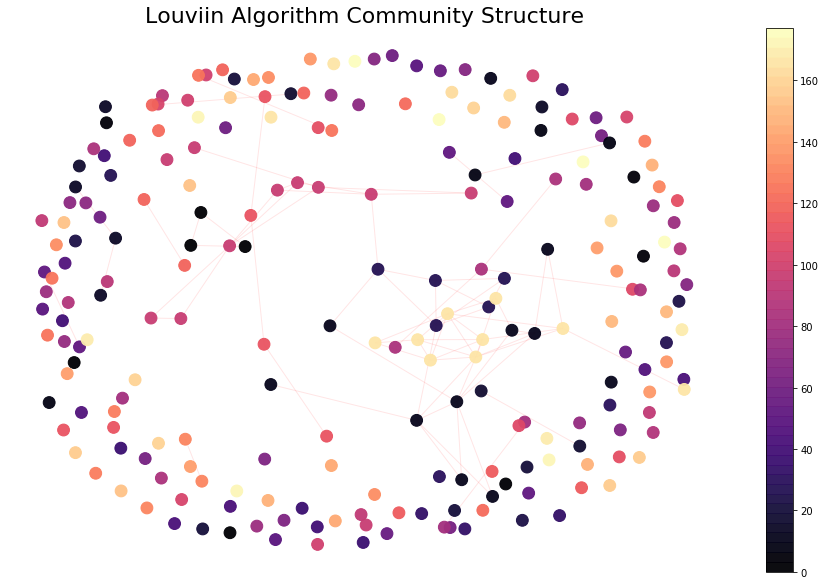

In [38]:
import community
import matplotlib.pyplot as plt
partition = community.best_partition(tg)

values = [partition.get(node) for node in tg.nodes()]
values=[partition.get(node) for node in tg.nodes()]
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(tg, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(tg, pos, node_size=140, label=True, cmap=plt.get_cmap('magma', len(tg.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(tg, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

In [39]:
community.modularity(partition, tg)

0.7398093359631819

In [40]:
partition = sorted(partition.items(), key=lambda kv: kv[1], reverse=False)

In [41]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in partition:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (mod_texts[word])
        current=cluster
    else:
        print (mod_texts[word])

--------------cluster 0------------ 
 
please take a look at this document.
--------------cluster 1------------ 
 
Will need your inputs to refine this document.
--------------cluster 2------------ 
 
We ll also have a discussion tomorrow once everyone is in.
--------------cluster 3------------ 
 
deploying meet master on liveclient and recorder.
Deploying meet master on staging liveclient and recorder.
Deploying meet master on staging liveclient and recorder.
--------------cluster 4------------ 
 
Found a couple of other issues with the production desktop build today.
--------------cluster 5------------ 
 
The sorting does not seem to be correct.
--------------cluster 6------------ 
 
Can you please double check this could be an API issue After I selected a channel I m unable to pick a different channel.
--------------cluster 7------------ 
 
Let s plan on a sync in the office XnumberX AM.
let s have a sync at XnumberX today.
--------------cluster 8------------ 
 
we can do that denyi